# Importing Libraries


In [3]:
!pip install music21
!apt-get install -y lilypond

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  fonts-droid-fallback fonts-lmodern fonts-noto-mono ghostscript gsfonts
  libauthen-sasl-perl libcupsfilters1 libcupsimage2 libdata-dump-perl
  libencode-locale-perl libfile-listing-perl libfont-afm-perl libgs9
  libgs9-common libhtml-form-perl libhtml-format-perl libhtml-parser-perl
  libhtml-tagset-perl libhtml-tree-perl libhttp-cookies-perl
  libhttp-daemon-perl libhttp-date-perl libhttp-message-perl
  libhttp-negotiate-perl libijs-0.35 libio-html-perl libio-socket-ssl-perl
  libjbig2dec0 libkpathsea6 liblwp-mediatypes-perl liblwp-protocol-https-perl
  libmailtools-perl libnet-http-perl libnet-smtp-ssl-perl libnet-ssleay-perl
  libpotrace0 libptexenc1 libsynctex1 libtexlua52 libtexluajit2
  libtext-unidecode-perl libtimedate-perl libtry-tiny-perl liburi-perl
  libwww-perl libwww-robotrules-perl libxml-libxml-perl
  libxml-namespacesupp

In [4]:
import tensorflow 
import numpy as np 
import pandas as pd 
import glob
import os
from collections import Counter
import random
import IPython
from IPython.display import Image, Audio
import music21
from music21 import *
import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import tensorflow.keras.backend as K
from tensorflow.keras.optimizers import Adamax
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
%matplotlib inline
import sys
import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter("ignore")
np.random.seed(42)

In [5]:
cd beeth/

/content/beeth


# Transposing all midi files to C major or A minor

In [6]:
majors = dict([("A-", 4),("G#", 4),("A", 3),("B-", 2),("A#", 2),("B", 1),("C", 0),("D-", -1),("C#", -1),("D", -2),("E-", -3),("D#", -3),("E", -4),("F", -5),("G-", 6),("F#", 6),("G", 5)])
minors = dict([("A-", 1),("G#", 1),("A", 0),("B-", -1),("A#", -1),("B", -2),("C", -3),("D-", -4),("C#", -4),("D", -5),("E-", 6),("D#", 6),("E", 5),("F", 4),("G-", 3),("F#", 3),("G", 2)])


for file in glob.glob("*.mid"):
    score = music21.converter.parse(file)
    key = score.analyze('key')
    if key.mode == "major":
        halfSteps = majors[key.tonic.name]
    elif key.mode == "minor":
        halfSteps = minors[key.tonic.name]
    newscore = score.transpose(halfSteps)
    key = newscore.analyze('key')
    print (key.tonic.name, key.mode)
    newFileName = "C_"+file
    newscore.write('midi',newFileName)

C major
C major
A minor
C major
A minor
C major
A minor
A minor
C major
A minor
A minor
A minor
C major
C major
C major
C major
A minor
A minor
C major
A minor
C major
C major
C major
A minor
A minor
A minor
C major
C major
C major


In [7]:
#Loading the list of beethoven's midi files as stream 
filepath = "../beeth/"
#Getting midi files
all_midis= []
for i in os.listdir(filepath):
    if i.startswith("C_"):
        tr = filepath+i
        midi = converter.parse(tr)
        all_midis.append(midi)

# Creating the corpus of music notes/chords

In [8]:
#Helping function        
def extract_notes(file):
    notes = []
    pick = None
    for j in file:
        songs = instrument.partitionByInstrument(j)
        for part in songs.parts:
            pick = part.recurse()
            for element in pick:
                if isinstance(element, note.Note):
                    notes.append(str(element.pitch))
                elif isinstance(element, chord.Chord):
                    notes.append(".".join(str(n) for n in element.normalOrder))

    return notes
#Getting the list of notes as Corpus
Corpus= extract_notes(all_midis)
print("Total notes in all the Beethoven midis in the dataset:", len(Corpus))

Total notes in all the Beethoven midis in the dataset: 85040


In [9]:
print("First fifty values in the Corpus:", Corpus[:50])

First fifty values in the Corpus: ['C4', '0', 'E4', '4', '4.9', '0.4', '4.9', 'C5', '0.4', '4.9', '4.9', '0.4', '8.11.2.4', '11.4', '9.0.4', '4.9', '9.2', '5', '5.9', '2', '5.9', '2', '4.9', '0', '4.9', '0', '2.4.8', '11', '9.0.4', '9', '11.4', '8', '11.2.5', '2.5.8.11', '11.2.5', '8', 'F4', '0.4', '9', '2.5.8', '11', '2.5.8', '11', '2.5.8', '11', '9.0.4', '0', '5.9.11', '2', '6.9.11']


# Preprocessing

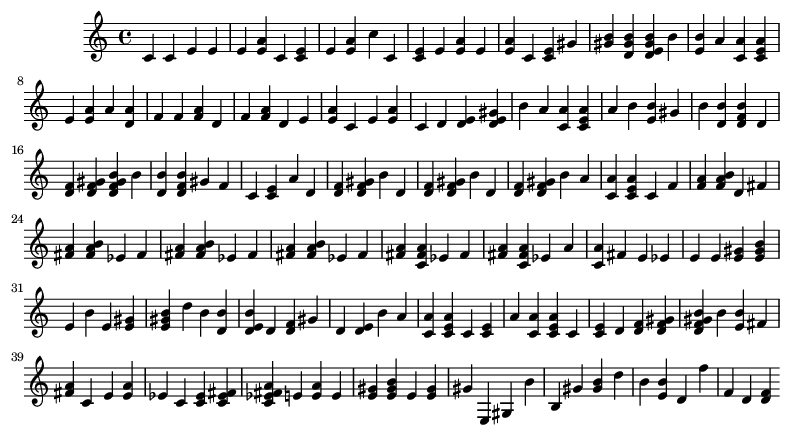

In [10]:
#First Lets write some functions that we need to look into the data
def show(music):
    display(Image(str(music.write("lily.png"))))
    
def chords_n_notes(Snippet):
    Melody = []
    offset = 0 #Incremental
    for i in Snippet:
        #If it is chord
        if ("." in i or i.isdigit()):
            chord_notes = i.split(".") #Seperating the notes in chord
            notes = [] 
            for j in chord_notes:
                inst_note=int(j)
                note_snip = note.Note(inst_note)            
                notes.append(note_snip)
                chord_snip = chord.Chord(notes)
                chord_snip.offset = offset
                Melody.append(chord_snip)
        # pattern is a note
        else: 
            note_snip = note.Note(i)
            note_snip.offset = offset
            Melody.append(note_snip)
        # increase offset each iteration so that notes do not stack
        offset += 1
    Melody_midi = stream.Stream(Melody)   
    return Melody_midi

Melody_Snippet = chords_n_notes(Corpus[:100])
show(Melody_Snippet)

In [11]:
#Creating a count dictionary
count_num = Counter(Corpus)
print("Total unique notes in the Corpus:", len(count_num))

Total unique notes in the Corpus: 270


In [12]:
#Exploring the notes dictionary
Notes = list(count_num.keys())
Recurrence = list(count_num.values())
#Average recurrence for a note in Corpus
def Average(lst):
    return sum(lst) / len(lst)
print("Average recurrence for a note in Corpus:", Average(Recurrence))
print("Most frequent note in Corpus appeared:", max(Recurrence), "times")
print("Least frequent note in Corpus appeared:", min(Recurrence), "time")

Average recurrence for a note in Corpus: 314.962962962963
Most frequent note in Corpus appeared: 2727 times
Least frequent note in Corpus appeared: 1 time


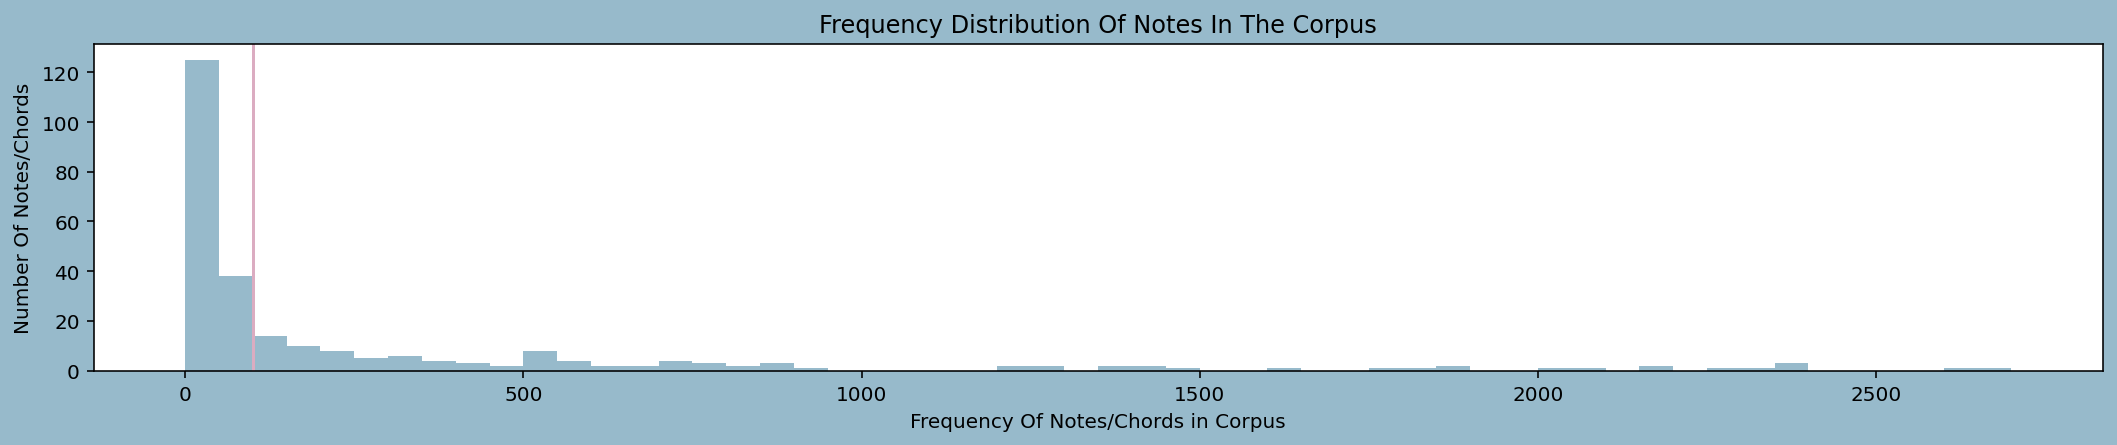

In [13]:
# Plotting the distribution of Notes
plt.figure(figsize=(18,3),facecolor="#97BACB")
bins = np.arange(0,(max(Recurrence)), 50) 
plt.hist(Recurrence, bins=bins, color="#97BACB")
plt.axvline(x=100,color="#DBACC1")
plt.title("Frequency Distribution Of Notes In The Corpus")
plt.xlabel("Frequency Of Notes/Chords in Corpus")
plt.ylabel("Number Of Notes/Chords")
plt.show()

In [14]:
#Getting a list of rare chords
rare_note = []
for index, (key, value) in enumerate(count_num.items()):
    if value < 100:
        m =  key
        rare_note.append(m)
        
print("Total number of notes that occur less than 100 times:", len(rare_note))

Total number of notes that occur less than 100 times: 163


In [15]:
#Eliminating the rare notes
for element in Corpus:
    if element in rare_note:
        Corpus.remove(element)

print("Length of Corpus after elemination the rare notes:", len(Corpus))

Length of Corpus after elemination the rare notes: 81421


In [16]:
# Storing all the unique characters present in my corpus to bult a mapping dic. 
symb = sorted(list(set(Corpus)))

L_corpus = len(Corpus) #length of corpus
L_symb = len(symb) #length of total unique characters


#Building dictionary to access the vocabulary from indices and vice versa
mapping = dict((c, i) for i, c in enumerate(symb))
reverse_mapping = dict((i, c) for i, c in enumerate(symb))

print("Total number of characters:", L_corpus)
print("Number of unique characters:", L_symb)

Total number of characters: 81421
Number of unique characters: 215


In [17]:
#Splitting the Corpus in equal length of strings and output target
length = 40
features = []
targets = []
for i in range(0, L_corpus - length, 1):
    feature = Corpus[i:i + length]
    target = Corpus[i + length]
    features.append([mapping[j] for j in feature])
    targets.append(mapping[target])
    
    
L_datapoints = len(targets)
print("Total number of sequences in the Corpus:", L_datapoints)

Total number of sequences in the Corpus: 81381


In [18]:
# reshape X and normalize
X = (np.reshape(features, (L_datapoints, length, 1)))/ float(L_symb)
# one hot encode the output variable
y = tensorflow.keras.utils.to_categorical(targets)

In [19]:
#Taking out a subset of data to be used as seed
X_train, X_seed, y_train, y_seed = train_test_split(X, y, test_size=0.2, random_state=42)

# Creating the LSTM model

In [20]:
#Initialising the Model
model = Sequential()
#Adding layers
model.add(LSTM(512, input_shape=(X.shape[1], X.shape[2]), return_sequences=True))
model.add(Dropout(0.3))
model.add(LSTM(256))
model.add(Dense(256))
model.add(Dropout(0.3))
model.add(Dense(y.shape[1], activation='softmax'))
#Compiling the model for training  
opt = Adamax(learning_rate=0.01)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics = ['accuracy'])

In [21]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 40, 512)           1052672   
_________________________________________________________________
dropout (Dropout)            (None, 40, 512)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 256)               787456    
_________________________________________________________________
dense (Dense)                (None, 256)               65792     
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 215)               55255     
Total params: 1,961,175
Trainable params: 1,961,175
Non-trainable params: 0
______________________________________________

# Training the model

In [22]:
history = model.fit(X_train, y_train, batch_size=128, epochs=100)

Epoch 1/100
509/509 [==============================] - 37s 58ms/step - loss: 4.3833 - accuracy: 0.0299
Epoch 2/100
509/509 [==============================] - 29s 58ms/step - loss: 4.3461 - accuracy: 0.0307
Epoch 3/100
509/509 [==============================] - 29s 58ms/step - loss: 4.3421 - accuracy: 0.0317
Epoch 4/100
509/509 [==============================] - 29s 58ms/step - loss: 4.3391 - accuracy: 0.0325
Epoch 5/100
509/509 [==============================] - 29s 58ms/step - loss: 4.3382 - accuracy: 0.0319
Epoch 6/100
509/509 [==============================] - 29s 57ms/step - loss: 4.3381 - accuracy: 0.0314
Epoch 7/100
509/509 [==============================] - 29s 57ms/step - loss: 4.3371 - accuracy: 0.0312
Epoch 8/100
509/509 [==============================] - 29s 57ms/step - loss: 4.3343 - accuracy: 0.0319
Epoch 9/100
509/509 [==============================] - 29s 57ms/step - loss: 4.3346 - accuracy: 0.0320
Epoch 10/100
509/509 [==============================] - 29s 57ms/step - l

[Text(0.5, 0, 'Epochs')]

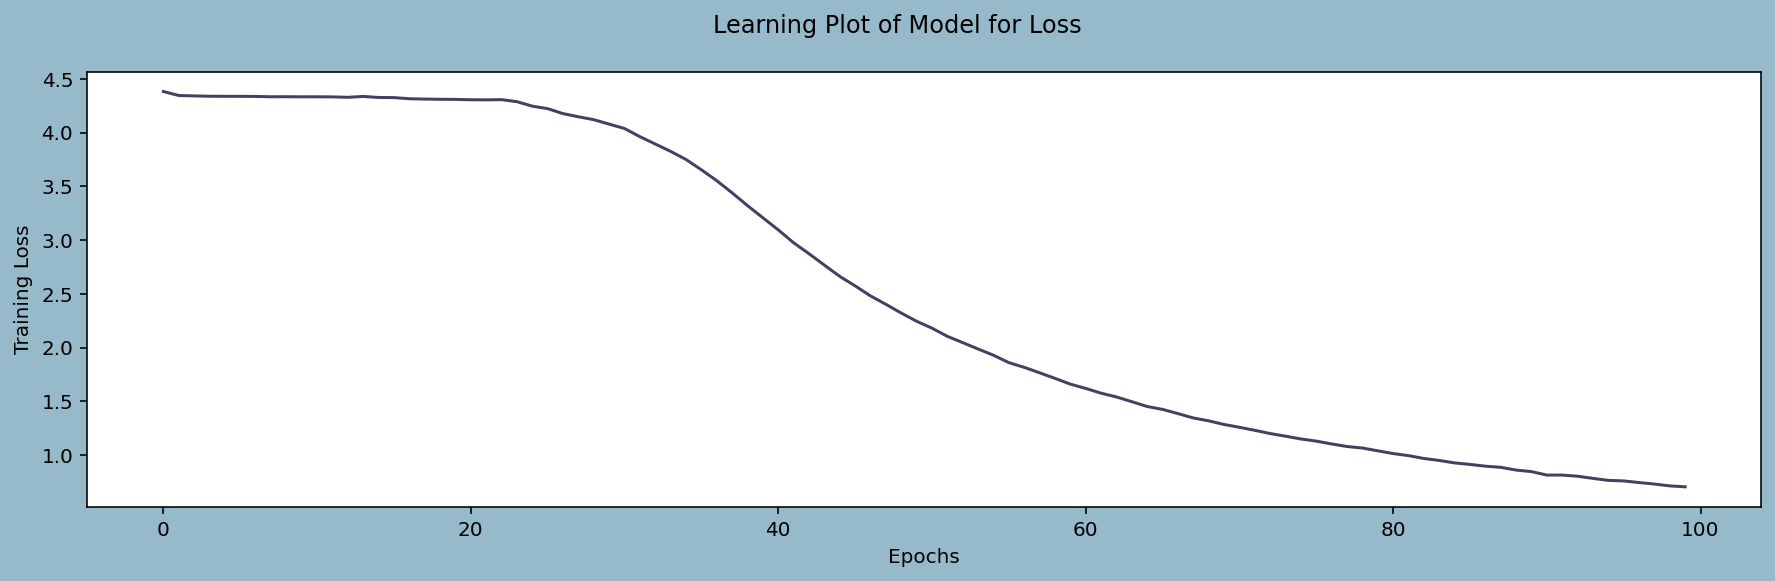

In [23]:
history_df = pd.DataFrame(history.history)
fig = plt.figure(figsize=(15,4), facecolor="#97BACB")
fig.suptitle("Learning Plot of Model for Loss")
pl=sns.lineplot(data=history_df["loss"],color="#444160")
pl.set(ylabel ="Training Loss")
pl.set(xlabel ="Epochs")

# Generating the midi file

In [26]:
def Melody_Generator(Note_Count):
    seed = X_seed[np.random.randint(0,len(X_seed)-1)]
    Music = ""
    Notes_Generated=[]
    for i in range(Note_Count):
        seed = seed.reshape(1,length,1)
        prediction = model.predict(seed, verbose=0)[0]
        prediction = np.log(prediction) / 1.0 #diversity
        exp_preds = np.exp(prediction)
        prediction = exp_preds / np.sum(exp_preds)
        index = np.argmax(prediction)
        index_N = index/ float(L_symb)   
        Notes_Generated.append(index)
        Music = [reverse_mapping[char] for char in Notes_Generated]
        seed = np.insert(seed[0],len(seed[0]),index_N)
        seed = seed[1:]
        
    Melody = chords_n_notes(Music)
    Melody_midi = stream.Stream(Melody)   
    return Music,Melody_midi

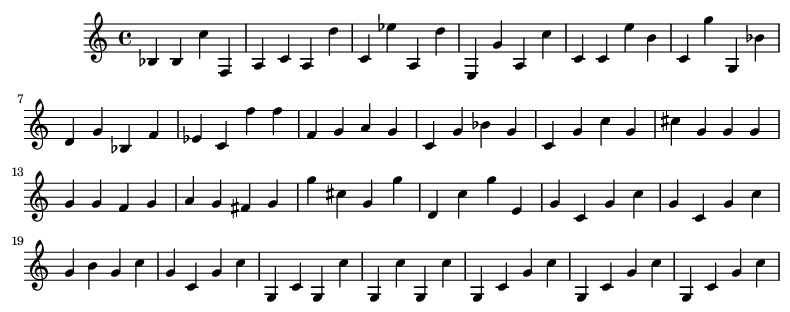

In [30]:
Music_notes, Melody = Melody_Generator(100)
show(Melody)

In [32]:
cd ..

/content


In [33]:
#To save the generated melody
Melody.write('midi','Melody_Generated.mid')
#to play audio or corpus

'Melody_Generated.mid'